# Analyze generated smiles
生成したリガンドを分析するノートブック

In [18]:
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity
from scipy.spatial.distance import pdist, squareform

In [2]:
with open('../config/filepath.yml') as file:
    path_config = yaml.safe_load(file)

with open('../config/model.yml') as file:
    model_config = yaml.safe_load(file)

with open('../config/data.yml') as file:
    data_config = yaml.safe_load(file)

dude_dir = os.path.join('..', path_config['data']['DUD-E'])
alphafold_dir = os.path.join('..', path_config['data']['alphafold'])
smiles_dir = os.path.join('..', path_config['data']['smiles'])
output_dir = os.path.join('..', path_config['data']['plots'])
hist_dir = os.path.join('..', path_config['data']['hist'])
eval_dir = os.path.join('..', path_config['data']['eval'], 'decoder_only')
preprocessed_dir = os.path.join('..', path_config['data']['preprocessed'])
sample_dir = os.path.join('..', path_config['data']['samples'])
model_dir = os.path.join('..', path_config['data']['docking'])
test_dir = os.path.join('..', path_config['data']['test'])

ds_reg_output_dir = os.path.join(output_dir, 'ds_regression')


In [3]:
def filter_valid_smiles(input_df, smiles_column="Generated_SMILES"):
    """
    Filters valid SMILES from a CSV file and calculates the valid SMILES ratio.

    Args:
        input_csv (str): Path to the input CSV file.
        smiles_column (str): Column name containing SMILES strings in the input CSV.

    Returns:
        float: The ratio of valid SMILES.
    """

    # Check if the SMILES column exists
    if smiles_column not in input_df.columns:
        raise ValueError(f"Column '{smiles_column}' not found in the input CSV.")

    # Check validity of SMILES
    input_df['is_valid'] = input_df[smiles_column].apply(lambda x: Chem.MolFromSmiles(x) is not None)

    # Calculate the valid SMILES ratio
    valid_ratio = input_df['is_valid'].mean()

    # Filter only valid SMILES
    valid_data = input_df[input_df['is_valid']].drop(columns=['is_valid'])

    return valid_ratio, valid_data

In [4]:
def plot_docking_scores_with_seed(seed_data, generated_data, 
                                      actual_score_column='r_i_docking_score',
                                      title_column='title', 
                                      ligand_id_column='Ligand_id', 
                                      docking_score_column='Docking_score',
                                      score_threshold=(-15, 0)):
    """
    Plots boxplots for docking scores of generated compounds per seed compound,
    filtering out invalid or extreme docking scores based on a specified threshold
    and retaining only the best (lowest) docking score for each unique title.

    Args:
        seed_data (DataFrame): DataFrame containing seed compounds and their docking scores.
        generated_data (DataFrame): DataFrame containing generated compounds and their docking scores.
        actual_score_column (str): Column in generated_data with actual docking scores.
        title_column (str): Column in generated_data containing titles to link to seed compounds.
        ligand_id_column (str): Column in seed_data containing ligand IDs.
        docking_score_column (str): Column in seed_data with docking scores.
        score_threshold (tuple): Min and max values for valid docking scores (default: (-15, 0)).

    Returns:
        None
    """
    import matplotlib.pyplot as plt

    # Filter out invalid docking scores in the generated data
    valid_generated_data = generated_data[
        (generated_data[actual_score_column] >= score_threshold[0]) & 
        (generated_data[actual_score_column] <= score_threshold[1])
    ]

    # Retain only the best (lowest) docking score for each unique title
    best_generated_data = valid_generated_data.loc[
        valid_generated_data.groupby(title_column)[actual_score_column].idxmin()
    ]

    # Filter out invalid docking scores in the seed data
    valid_seed_data = seed_data[
        (seed_data[docking_score_column] >= score_threshold[0]) & 
        (seed_data[docking_score_column] <= score_threshold[1])
    ]

    # Group by each seed compound
    seed_ligand_ids = valid_seed_data[ligand_id_column].unique()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Collect data for boxplots
    boxplot_data = []
    labels = []
    seed_scores = []

    for ligand_id in seed_ligand_ids:
        # Filter generated compounds for this seed ligand
        filtered_generated = best_generated_data[
            best_generated_data[title_column].str.contains(ligand_id, na=False)
        ]

        if not filtered_generated.empty:
            # Add the best scores to the boxplot data
            boxplot_data.append(filtered_generated[actual_score_column].values)
            labels.append(ligand_id)

            # Find the seed docking score
            seed_score = valid_seed_data[
                valid_seed_data[ligand_id_column] == ligand_id
            ][docking_score_column].values[0]
            seed_scores.append(seed_score)

    # Plot boxplots
    box = ax.boxplot(boxplot_data, vert=True, patch_artist=True, labels=labels)
    ax.set_title("Filtered Best Docking Scores Per Seed Compound")
    ax.set_ylabel("Docking Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Overlay seed compound docking scores as red points
    for i, score in enumerate(seed_scores):
        ax.scatter([i + 1], [score], color='red', label="Seed Compound" if i == 0 else "", zorder=5)

    # Add legend
    ax.legend()

    # Adjust layout and show plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np


def calculate_canonical_smiles(smiles_list):
    """
    Converts a list of SMILES to their canonical form using RDKit.

    Args:
        smiles_list (list): List of SMILES strings.

    Returns:
        list: List of canonical SMILES strings.
    """
    canonical_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            canonical_smiles.append(Chem.MolToSmiles(mol))
    return canonical_smiles


def calculate_diversity(fingerprints):
    """
    Calculates the diversity of a set of molecules using Tanimoto similarity.

    Args:
        fingerprints (list): List of molecular fingerprints.

    Returns:
        float: Diversity score (1 - average pairwise Tanimoto similarity).
    """
    n = len(fingerprints)
    if n < 2:
        return 0  # Not enough data for diversity calculation

    similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            similarity = TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarities.append(similarity)

    avg_similarity = np.mean(similarities) if similarities else 0
    diversity = 1 - avg_similarity
    return diversity


def calculate_metrics_with_moses(generated_data, smiles_column='SMILES'):
    """
    Calculates validity, uniqueness (after canonicalization), and diversity using the MOSES benchmark method.

    Args:
        generated_data (DataFrame): DataFrame containing generated compounds.
        smiles_column (str): Column in the DataFrame containing SMILES strings.

    Returns:
        dict: A dictionary containing the validity, uniqueness, and diversity metrics.
    """
    # Extract SMILES strings
    smiles_list = generated_data[smiles_column].tolist()

    # 1. Validity: Check if each SMILES string can be converted to a valid molecule
    valid_smiles = [smiles for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
    validity = len(valid_smiles) / len(smiles_list) if smiles_list else 0

    # 2. Canonicalize valid SMILES
    canonical_smiles = calculate_canonical_smiles(valid_smiles)

    # 3. Uniqueness: Calculate the ratio of unique canonical SMILES to all canonical SMILES
    unique_smiles = set(canonical_smiles)
    uniqueness = len(unique_smiles) / len(canonical_smiles) if canonical_smiles else 0

    # 4. Diversity: Calculate diversity using pairwise Tanimoto similarity
    mols = [Chem.MolFromSmiles(smiles) for smiles in unique_smiles]
    fingerprints = [
        AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        for mol in mols if mol is not None
    ]
    diversity = calculate_diversity(fingerprints) if fingerprints else 0

    return {
        'validity': validity,
        'uniqueness': uniqueness,
        'diversity': diversity
    }


# 再実行（RDKit がインストールされている環境で動作します）
# metrics = calculate_metrics_with_moses(drd3_best_docking, smiles_column='Generated_SMILES')
# print(metrics)


## DRD3 local model
drd3 のデータセットで学習し、ドッキングスコアの良いもの10個をシード化合物として生成した smiles

In [9]:
drd3_model_timestamp = '2025-01-10_20-12-20'
drd3_best_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'best_docking.csv'))

In [13]:
bd_valid_ratio, bd_valid_data = filter_valid_smiles(drd3_best_docking)
print(f"Valid SMILES ratio: {bd_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(bd_valid_data)}")

Valid SMILES ratio: 86.30
Number of valid SMILES: 863


[01:33:17] Explicit valence for atom # 28 N, 4, is greater than permitted
[01:33:17] SMILES Parse Error: extra close parentheses while parsing: O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[01:33:17] SMILES Parse Error: check for mistakes around position 43:
[01:33:17] 3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[01:33:17] ~~~~~~~~~~~~~~~~~~~~^
[01:33:17] SMILES Parse Error: Failed parsing SMILES 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21' for input: 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21'
[01:33:17] Explicit valence for atom # 7 N, 6, is greater than permitted
[01:33:17] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c(N3CCO[C@@H]4C3)c(C(=O)Nc3ccc(F)cc3C(F)(F)F)ccc2o1'
[01:33:17] SMILES Parse Error: unclosed ring for input: 'C[C@H]1[C@H]2[C@@H](c3ccccc3)Nc3cc(C[NH2+]C[C@@H](C)O)ccc2N(CC(=O)N(C)C)C1=O'
[01:33:17] SMILES Parse Error: unclosed ring for input: 'Cc1ccc2c(C)c(C(=O)NC3CC4CCC(CC(=O)NC5CCCCC5)[C@H](C)C3)sc2n1'
[01:33:17] Explicit valence for a

/tmp/ipykernel_73749/2628229564.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(boxplot_data, vert=True, patch_artist=True, labels=labels)


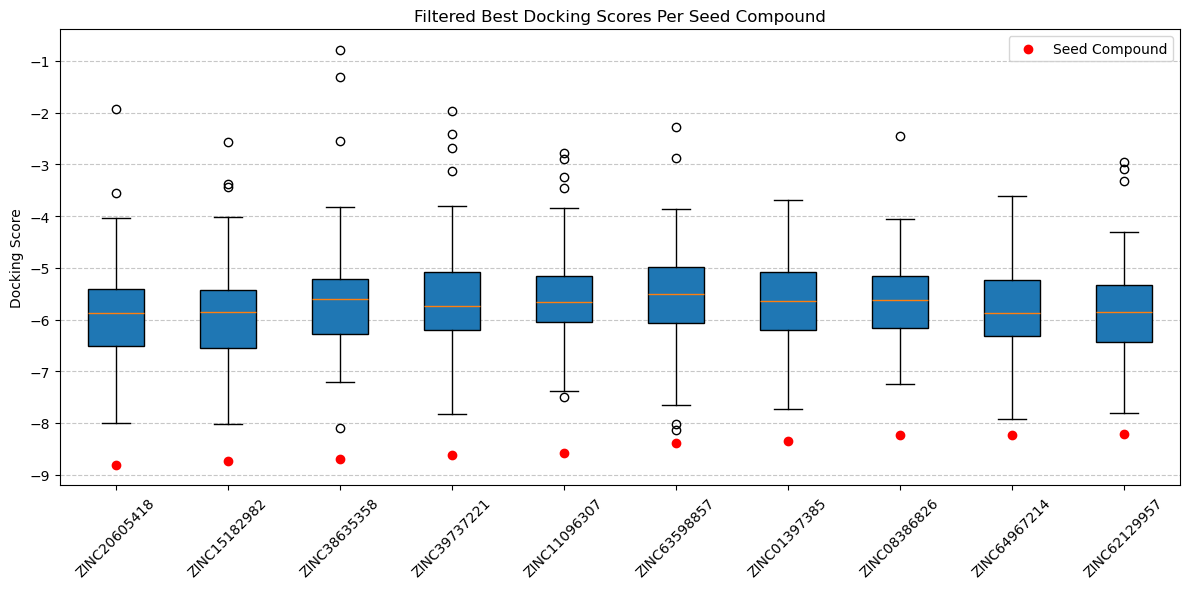

In [7]:
best_score_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'best_score_docking.csv'))
top_10_docking_scores = pd.read_csv(os.path.join(test_dir, 'Top_10_Docking_Scores.csv'))

seed_score = -8.806
seed_predicted_score = -5.860
# Run the function on the provided datasets with a score threshold
plot_docking_scores_with_seed(
    seed_data=top_10_docking_scores,
    generated_data=best_score_docking,
    actual_score_column="r_i_docking_score",
    title_column="title",
    ligand_id_column="Ligand_id",
    docking_score_column="Docking_score",
    score_threshold=(-15, 0)
)

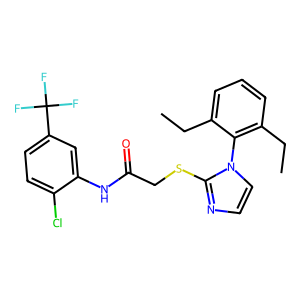

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = "CCc1cccc(CC)c1-n1ccnc1SCC(=O)Nc1cc(C(F)(F)F)ccc1Cl"
molecule = Chem.MolFromSmiles(smiles)
Draw.MolToImage(molecule)

In [17]:
metrics = calculate_metrics_with_moses(drd3_best_docking, smiles_column='Generated_SMILES')
print(metrics)

[11:53:34] Explicit valence for atom # 28 N, 4, is greater than permitted
[11:53:34] SMILES Parse Error: extra close parentheses while parsing: O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[11:53:34] SMILES Parse Error: check for mistakes around position 43:
[11:53:34] 3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[11:53:34] ~~~~~~~~~~~~~~~~~~~~^
[11:53:34] SMILES Parse Error: Failed parsing SMILES 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21' for input: 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21'
[11:53:34] Explicit valence for atom # 7 N, 6, is greater than permitted
[11:53:34] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c(N3CCO[C@@H]4C3)c(C(=O)Nc3ccc(F)cc3C(F)(F)F)ccc2o1'
[11:53:34] SMILES Parse Error: unclosed ring for input: 'C[C@H]1[C@H]2[C@@H](c3ccccc3)Nc3cc(C[NH2+]C[C@@H](C)O)ccc2N(CC(=O)N(C)C)C1=O'
[11:53:34] SMILES Parse Error: unclosed ring for input: 'Cc1ccc2c(C)c(C(=O)NC3CC4CCC(CC(=O)NC5CCCCC5)[C@H](C)C3)sc2n1'
[11:53:34] Explicit valence for a

{'validity': 0.863, 'uniqueness': 1.0, 'diversity': np.float64(0.8878664991598366)}


ランダムにシードを選んで生成したsmiles

In [15]:
drd3_random = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'random.csv'))
random_valid_ratio, random_valid_data = filter_valid_smiles(drd3_random)
print(f"Valid SMILES ratio: {random_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(random_valid_data)}")

Valid SMILES ratio: 83.30
Number of valid SMILES: 833


[02:21:34] SMILES Parse Error: syntax error while parsing: COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]
[02:21:34] SMILES Parse Error: check for mistakes around position 31:
[02:21:34] =O)CSc2nc3ccccc3[nH2)ccc1=[NH+]
[02:21:34] ~~~~~~~~~~~~~~~~~~~~^
[02:21:34] SMILES Parse Error: Failed parsing SMILES 'COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]' for input: 'COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]'
[02:21:34] SMILES Parse Error: syntax error while parsing: Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C
[02:21:34] SMILES Parse Error: check for mistakes around position 28:
[02:21:34] c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C
[02:21:34] ~~~~~~~~~~~~~~~~~~~~^
[02:21:34] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C' for input: 'Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C'
[02:21:34] SMILES Parse Error: unclosed ring for input: 'C=CCN(CC=C)S(=O)(=O)c1ccc2c(c1)NC(=O)[C@@H](C)[NH2+]C1=CC2=c3cccc(O)c3N=[NH+]C2=S'
[02:21:34] Can't kekulize mol.  Unk

ドッキングスコア予測のよいものをシードにして生成したSMILES

In [16]:
drd3_accurate = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'accurate.csv'))
accurate_valid_ratio, accurate_valid_data = filter_valid_smiles(drd3_accurate)
print(f"Valid SMILES ratio: {accurate_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(accurate_valid_data)}")

Valid SMILES ratio: 84.90
Number of valid SMILES: 849


[02:22:54] SMILES Parse Error: extra close parentheses while parsing: FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1
[02:22:54] SMILES Parse Error: check for mistakes around position 51:
[02:22:54] (=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1
[02:22:54] ~~~~~~~~~~~~~~~~~~~~^
[02:22:54] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1' for input: 'FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1'
[02:22:54] SMILES Parse Error: extra open parentheses while parsing: O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl
[02:22:54] SMILES Parse Error: check for mistakes around position 4:
[02:22:54] O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)
[02:22:54] ~~~^
[02:22:54] SMILES Parse Error: Failed parsing SMILES 'O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl' for input: 'O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl'
[02:22:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 12 13 14 17 18
[02:22:54] Explici

ドッキングスコアのbinごとに区切ってランダムにサンプリングしたシードから生成したSMILES

/tmp/ipykernel_73749/2628229564.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(boxplot_data, vert=True, patch_artist=True, labels=labels)


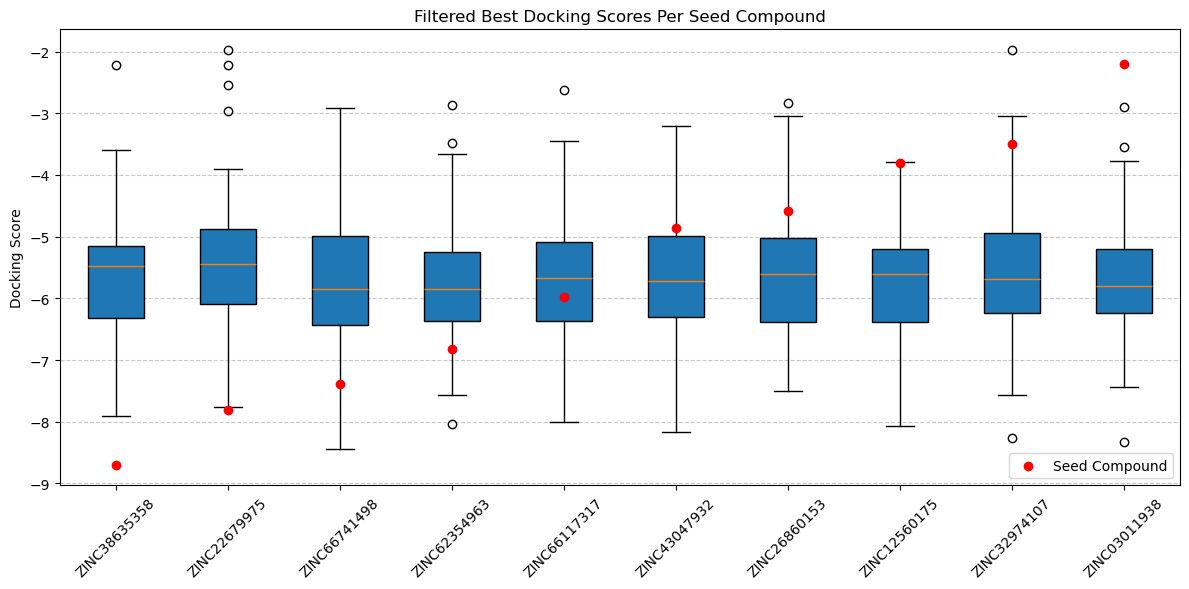

In [25]:
seed_dir = os.path.join(eval_dir, '..', 'ds_regression', '2025-01-03_22-35-27')
binwise_random_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'binwise_random_docking.csv'))
binwise_seed = pd.read_csv(os.path.join(seed_dir, 'binwise_random.csv'))

plot_docking_scores_with_seed(
    seed_data=binwise_seed,
    generated_data=binwise_random_docking,
    actual_score_column="r_i_docking_score",
    title_column="title",
    ligand_id_column="Ligand_ID",
    docking_score_column="Actual_Docking_Score",
    score_threshold=(-15, 0)
)

ドッキングスコアのbinごとに区切って予測結果のよかったシードから生成したSMILES

/tmp/ipykernel_73749/2628229564.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(boxplot_data, vert=True, patch_artist=True, labels=labels)


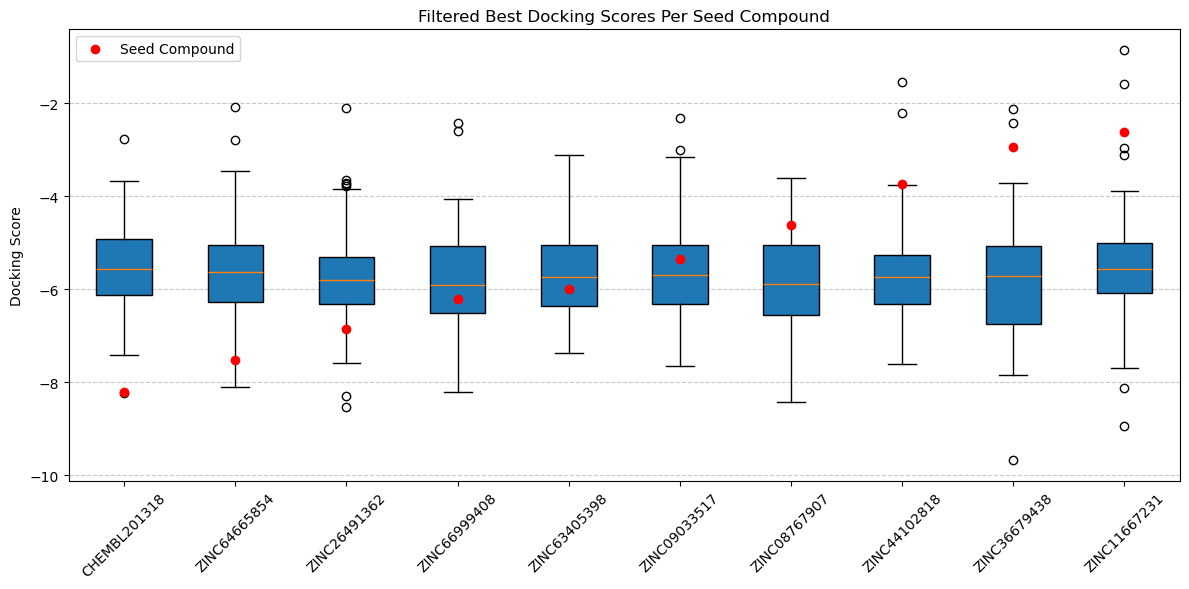

In [26]:
binwise_accurate_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'binwise_accurate_docking.csv'))
binwise_accurate_seed = pd.read_csv(os.path.join(seed_dir, 'binwise_accurate.csv'))

plot_docking_scores_with_seed(
    seed_data=binwise_accurate_seed,
    generated_data=binwise_accurate_docking,
    actual_score_column="r_i_docking_score",
    title_column="title",
    ligand_id_column="Ligand_ID",
    docking_score_column="Actual_Docking_Score",
    score_threshold=(-15, 0)
)